<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/dqn_pong__________2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import time
import random
import numpy as np

import gym

import matplotlib.pyplot as plt
%matplotlib inline

gym.__version__

'0.15.4'

## Load GYM environment

In [81]:
env = gym.make('Pong-v0')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n

print('Actions: {}'.format(NUM_ACTIONS))
print('States shape: {}'.format(STATE_SHAPE))

Actions: 6
States shape: (210, 160, 3)


In [82]:
env.__dict__

{'_elapsed_steps': None,
 '_max_episode_steps': 10000,
 'action_space': Discrete(6),
 'env': <gym.envs.atari.atari_env.AtariEnv at 0x7fd0cff34cc0>,
 'metadata': {'render.modes': ['human', 'rgb_array']},
 'observation_space': Box(210, 160, 3),
 'reward_range': (-inf, inf)}

In [83]:
env.observation_space.shape[0]

210

## Example of a state

In [84]:
def epsilon_factory(arg_delta, min_num):
    def get_epsilon_for_iteration(i):
        y = (arg_delta ** -i) + min_num
        return y if y <= 1.0 else 1.0
    return get_epsilon_for_iteration

epsilon_factory(1.005, .25)(100)

0.8572867761711169

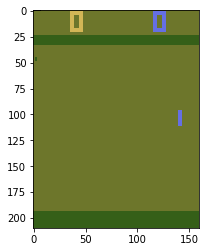

In [85]:
s = env.reset()
_=plt.imshow(s)

## DQN

In [0]:
# Train a DQN model here

def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img)).reshape(105,80,1)

In [87]:
# env.reset()
# env.render()
# env.step(env.action_space.sample())
state = env.step(2)[0]
state.shape

(210, 160, 3)

In [88]:
state = preprocess(state)
state.shape

(105, 80, 1)

In [91]:
stateA = state
a = stateA
a = np.append(a, stateA, axis=2)
a = np.append(a, stateA, axis=2)
a = np.append(a, stateA, axis=2)
a.shape

(105, 80, 4)

In [0]:
UP_ACTION = 2
DOWN_ACTION = 3
actions = np.array([UP_ACTION, DOWN_ACTION])

In [93]:
import keras
from keras.layers import Input, Lambda, Dense, Multiply, Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten
from keras.models import Model

def atari_model(n_actions):
    ATARI_SHAPE = (105, 80, 4)

    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
    actions_input = keras.layers.Input((n_actions,), name='mask')

    # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
    normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)
    
    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = Conv2D(16, (4, 4), subsample=(4, 4), activation='relu', name='conv_1')(normalized)
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = Conv2D(32, (2, 2), activation='relu', name='conv_2')(conv_1)
    # Flattening the second convolutional layer.
    conv_flattened = keras.layers.core.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = keras.layers.Dense(n_actions)(hidden)
    # Finally, we multiply the output by the mask!
    filtered_output = Multiply()([output, actions_input])

    model = keras.models.Model(input=[frames_input, actions_input], output=filtered_output)
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss='mse')

    return model

def q_eval(model, frames_input):
    p_result = model.predict([[frames_input], [np.ones(actions.shape)]])
    return p_result

model = atari_model(2)
q_eval(model, a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4), activation="relu", name="conv_1", strides=(4, 4))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mu...)`


array([[-0.1600479 ,  0.06050581]], dtype=float32)

In [0]:

class RingBuf:
    def __init__(self):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY, whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. This greatly simplifies the rest of the code.
        self.data = []
        self.start = 0
        self.end = 0
        
    def append(self, element):
        self.data.append(element)

    def sample_batch(self, size):
        if len(self.data) < size:
            return self.data
        limit = random.randint(0, len(self.data) - size)
        return self.data[limit:limit+size]
        
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

# rbf = RingBuf(40)
# for i in range(40):
#     rbf.append((1,2,3))
#     print(rbf.sample_batch(32))


In [104]:
def fit_batch(model, batch, gamma):
    """Do one deep Q learning iteration.
    
    Params:
    - model: The DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states
    - actions: numpy array of one-hot encoded actions corresponding to the start states
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states and actions
    - is_terminal: numpy boolean array of whether the resulting state is terminal
    
    """

    # a = stateA
    # a = np.append(a, stateA, axis=2)
    # a = np.append(a, stateA, axis=2)
    # a = np.append(a, stateA, axis=2)

    # start_states, actions, rewards, next_states
    start_states = batch[0][0]
    next_states = batch[0][2]
    rewardes = [batch[0][3]]

    for batch_item in batch[1:]:
        (state, action, new_state, reward, is_done) = batch_item
        start_states = np.append(start_states, state, axis=2)
        next_states = np.append(next_states, new_state, axis=2)
        rewardes.append(reward)

    avg_reward = int(sum(rewardes) / len(rewardes))

    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    next_Q_values = q_eval(model, start_states)
   
    # Make target vector
    targets = np.ones(2)
    maxQi = np.argmax(next_Q_values)
    targets[maxQi] = avg_reward + gamma * next_Q_values[0][maxQi]
    print(targets, actions, np.ones(actions.shape))
    # print(next_states.shape, start_states.shape)
    # print(next_states[0].shape, next_states[1].shape)

    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    # [[frames_input], [np.ones(actions.shape)]]

    model.fit([[next_states], [np.ones(actions.shape)]], [[targets]], epochs=1, verbose=0)
    print(999)

def q_init(env, memory):
    state = preprocess(env.reset())
    init_states = []
    for i in range(4):
        action = env.action_space.sample()
        new_state, reward, is_done, _ = env.step(action)
        new_state = preprocess(new_state)
        init_states.append(new_state)

        memory.append((state, action, new_state, reward, is_done))
        state = new_state
    return init_states


memory = RingBuf()
get_epsilon_for_iteration = epsilon_factory(1.005, .25)
total_reward = 0
model = atari_model(2)

init_states = q_init(env, memory)
for i in range(500):
    q_result = q_iteration(env, model, init_states, i, memory, get_epsilon_for_iteration)
    init_states.pop()
    init_states.append(q_result[0])

    total_reward += q_result[1]

    if i % 10 == 0:
        print(i, ',', total_reward)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4), activation="relu", name="conv_1", strides=(4, 4))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mu...)`


[1.         0.04929936] [2 3] [1. 1.]


999
0 , 0.0
[0.9815383 1.       ] [2 3] [1. 1.]
999
[0.9430531 1.       ] [2 3] [1. 1.]
999
[1.         0.86355994] [2 3] [1. 1.]
999
[0.84850904 1.        ] [2 3] [1. 1.]
999
[1.         0.89594316] [2 3] [1. 1.]
999
[0.86568913 1.        ] [2 3] [1. 1.]
999
[1.         0.86488001] [2 3] [1. 1.]
999
[0.89402195 1.        ] [2 3] [1. 1.]
999
[1.         0.71527761] [2 3] [1. 1.]
999
[0.78708898 1.        ] [2 3] [1. 1.]
999
10 , 0.0
[1.         0.87287155] [2 3] [1. 1.]
999
[0.87920263 1.        ] [2 3] [1. 1.]
999
[1.         0.86992965] [2 3] [1. 1.]
999
[0.87471476 1.        ] [2 3] [1. 1.]
999
[1.         0.86785104] [2 3] [1. 1.]
999
[0.87239814 1.        ] [2 3] [1. 1.]
999
[1.         0.71191685] [2 3] [1. 1.]
999
[0.79400355 1.        ] [2 3] [1. 1.]
999
[1.         0.86036505] [2 3] [1. 1.]
999
[0.88588681 1.        ] [2 3] [1. 1.]
999
20 , 0.0
[1.         0.85252056] [2 3] [1. 1.]
999
[0.8749715 1.       ] [2 3] [1. 1.]
999
[1.         

ValueError: ignored

In [0]:
def choose_best_action(model, state):
    return model.predict([state, np.ones(actions.shape)])
    
def q_iteration(env, model, init_states, iteration, memory, get_epsilon_for_iteration):
    # Choose epsilon based on the iteration
    epsilon = get_epsilon_for_iteration(iteration)

    # Choose the action 
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = actions[np.argmax(q_eval(model, init_states))]

    # Play one game iteration (note: according to the next paper, you should actually play 4 times here)
    new_state, reward, is_done, _ = env.step(action)
    new_state = preprocess(new_state)
    memory.append((state, action, new_state, reward, is_done))

    # Sample and fit
    batch = memory.sample_batch(4)
    fit_batch(model, batch, .9)
    return (new_state, reward)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4), activation="relu", name="conv_1", strides=(4, 4))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mu...)`


ValueError: ignored

## Virtual display and video recording for Colab

In [105]:
RECORD_VIDEO = True

if RECORD_VIDEO:
  
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


## Run simulation

In [130]:
if RECORD_VIDEO:
    from gym.wrappers import Monitor
    env_sim = Monitor(env, './video', force=True)
else:
    env_sim = env

init_state = env_sim.reset()
totalReward = 0

UP_ACTION = 2
DOWN_ACTION = 3

env_states = preprocess(init_state)
for i in range(3):
    state, reward, done, _ = env_sim.step(3)
    env_states = np.append(env_states, preprocess(state), axis=2)

print(env_states.shape)

for _ in range(1000):
    env_sim.render()
    q = q_eval(model, env_states)
    # print(actions[np.argmax(q[0])])

    state, reward, done, _ = env_sim.step(actions[np.argmax(q[0])])
    env_states = np.append(env_states, preprocess(state), axis=2)

    env_states = np.delete(env_states, 0, axis=2)

    totalReward += reward
    if done:        
        break
    
    if not RECORD_VIDEO:
        time.sleep(1./30)
        
env_sim.close()

print('Total reward = {}'.format(totalReward))

(105, 80, 4)
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2

## Show the video

In [125]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
show_video()